In this project we will create a Convolutional Neural Network which will be able to predict whether a plant is suffering from a disease. We will use different layers and other hyperparameters for building, training and testing this classifictaion model.We will be using tensorflow and keras for this project.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical


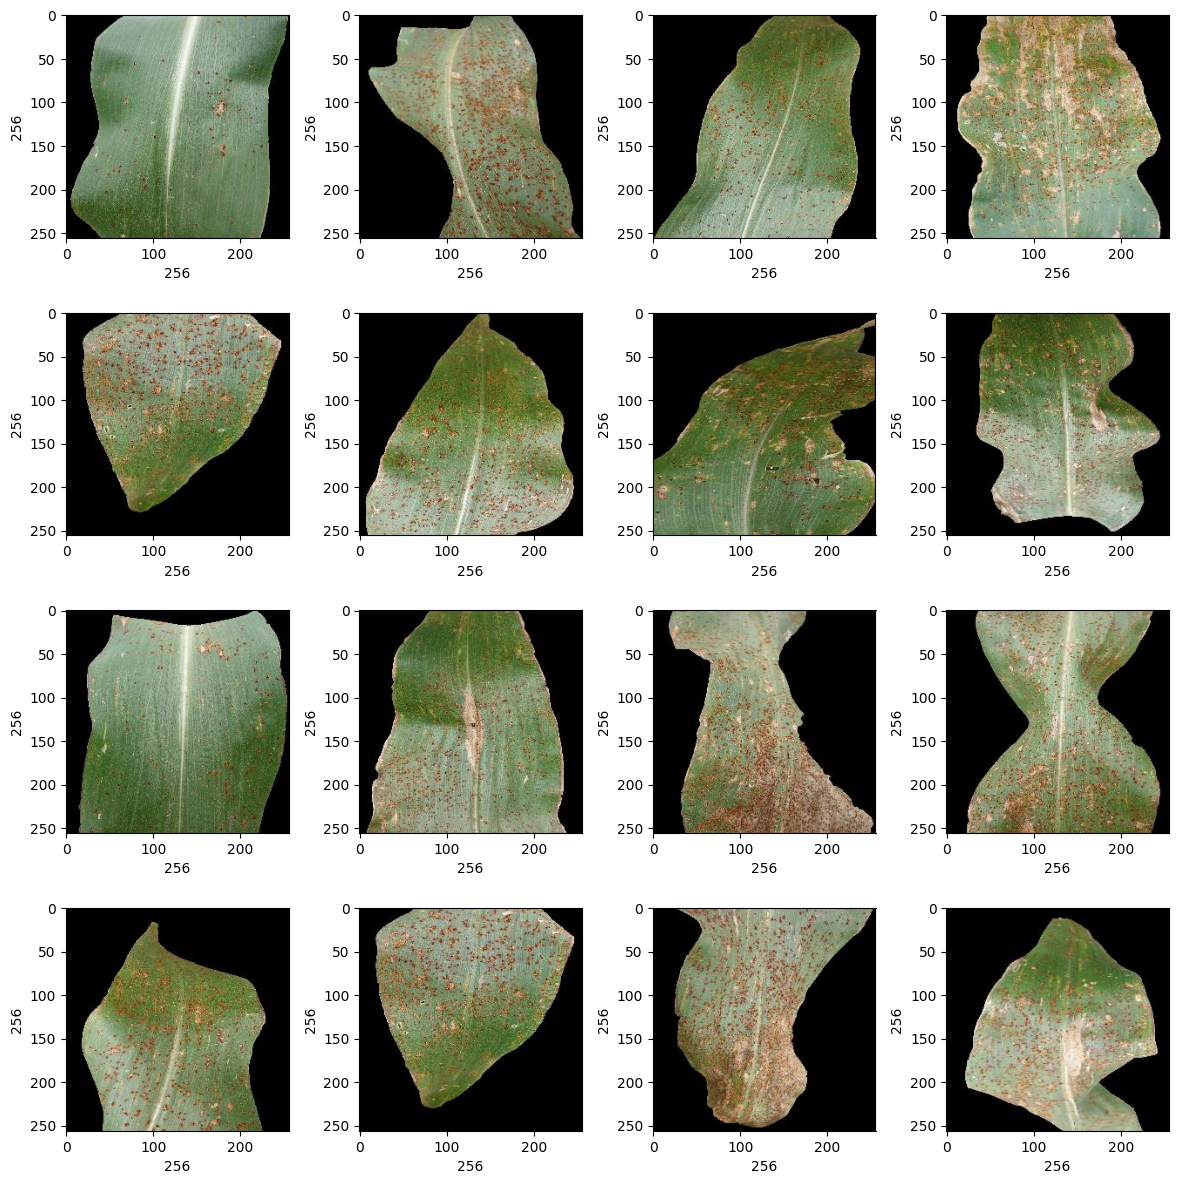

In [ ]:
# Plotting 12 images to check dataset
#Now we will observe some of the iamges that are their in our dataset. We will plot 12 images here using the matplotlib library.
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/DL project/Plant_images/Corn_(maize)___Common_rust_"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.

In [ ]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
dir = "/content/drive/MyDrive/DL project/Plant_images"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
#Now we will convert all the images into numpy array.

for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])



Now we will convert all the images into numpy array.


In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

#it is a balanced dataset as you can see

0    301
1    300
2    300
dtype: int64

In [ ]:
#Next we will observe the shape of the image.
image_list[0].shape

(256, 256, 3)

In [ ]:
#Checking the total number of the images which is the length of the labels list.
label_list = np.array(label_list)
label_list.shape

(901,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

In [ ]:

# Reshape the images to a consistent shape
image_size = (256, 256, 3)
x_train = [cv2.resize(img, image_size[:2]) for img in x_train]

# Filter out invalid images in x_test
x_test_resized = []
for img in x_test:
    if img is not None and img.shape[:2] == image_size[:2]:
        x_test_resized.append(img)

# Convert lists to NumPy arrays
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test_resized, dtype=np.float16) / 255.0

# Reshape the dataset
x_train = x_train.reshape(-1, *image_size)
x_test = x_test.reshape(-1, *image_size)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Next we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 85, 85, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 42, 42, 16)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 28224)             0         
                                                                 
 dense_4 (Dense)             (None, 8)                


While compiling the model we need to set the type of loss which will be Binary Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

In [ ]:
#Next we will split the dataset into validation and training data.
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [ ]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val, y_val))

Epoch 1/50
5/5 [==============================] - 2s 270ms/step - loss: 1.0566 - accuracy: 0.3819 - val_loss: 0.9890 - val_accuracy: 0.4792
Epoch 2/50
5/5 [==============================] - 1s 140ms/step - loss: 0.9225 - accuracy: 0.5990 - val_loss: 0.8511 - val_accuracy: 0.5833
Epoch 3/50
5/5 [==============================] - 1s 143ms/step - loss: 0.7820 - accuracy: 0.7240 - val_loss: 0.7089 - val_accuracy: 0.7917
Epoch 4/50
5/5 [==============================] - 1s 140ms/step - loss: 0.6455 - accuracy: 0.8750 - val_loss: 0.5646 - val_accuracy: 0.9236
Epoch 5/50
5/5 [==============================] - 1s 150ms/step - loss: 0.5280 - accuracy: 0.9236 - val_loss: 0.4588 - val_accuracy: 0.9306
Epoch 6/50
5/5 [==============================] - 1s 146ms/step - loss: 0.4274 - accuracy: 0.9375 - val_loss: 0.3809 - val_accuracy: 0.9444
Epoch 7/50
5/5 [==============================] - 1s 141ms/step - loss: 0.3507 - accuracy: 0.9306 - val_loss: 0.3107 - val_accuracy: 0.9444
Epoch 8/50
5/5 [====

In [ ]:
y_pred = model.predict(x_test)

6/6 [==============================] - 0s 14ms/step


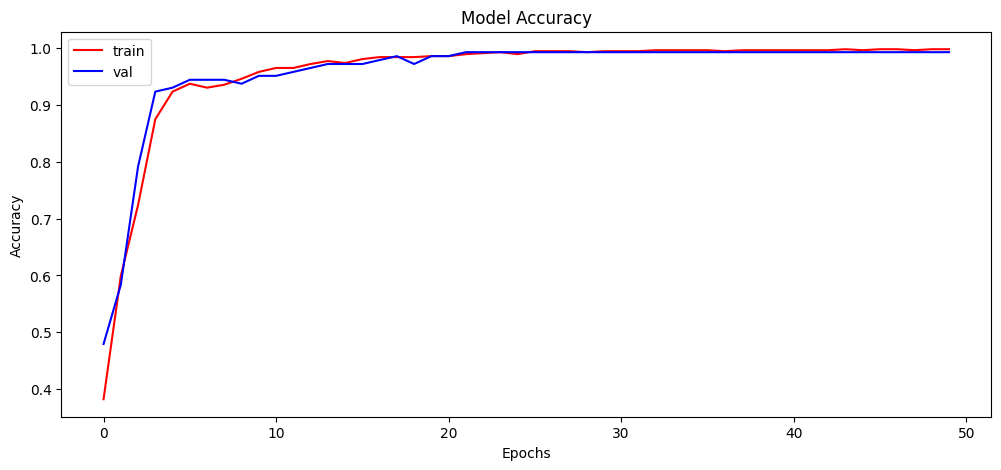

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

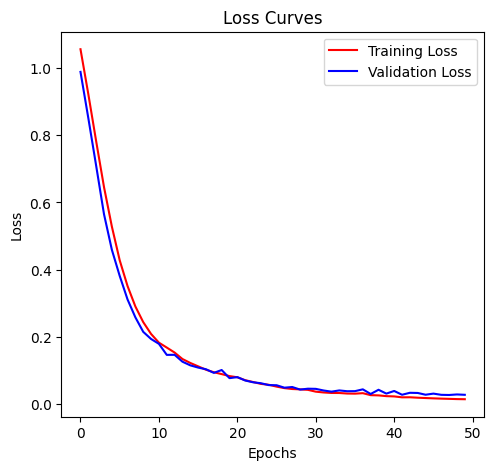

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='r')
plt.plot(history.history['val_loss'], label='Validation Loss', color='b')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Epoch 1/5
4/4 [==============================] - 2s 369ms/step - loss: 1.1170 - accuracy: 0.3164 - val_loss: 1.1037 - val_accuracy: 0.3047
Epoch 2/5
4/4 [==============================] - 1s 203ms/step - loss: 1.0995 - accuracy: 0.3242 - val_loss: 1.1031 - val_accuracy: 0.3047
Epoch 3/5
4/4 [==============================] - 1s 191ms/step - loss: 1.0991 - accuracy: 0.3242 - val_loss: 1.1017 - val_accuracy: 0.3047
Epoch 4/5
4/4 [==============================] - 1s 193ms/step - loss: 1.0985 - accuracy: 0.3242 - val_loss: 1.1007 - val_accuracy: 0.3047
Epoch 5/5
5/5 [==============================] - 0s 18ms/step


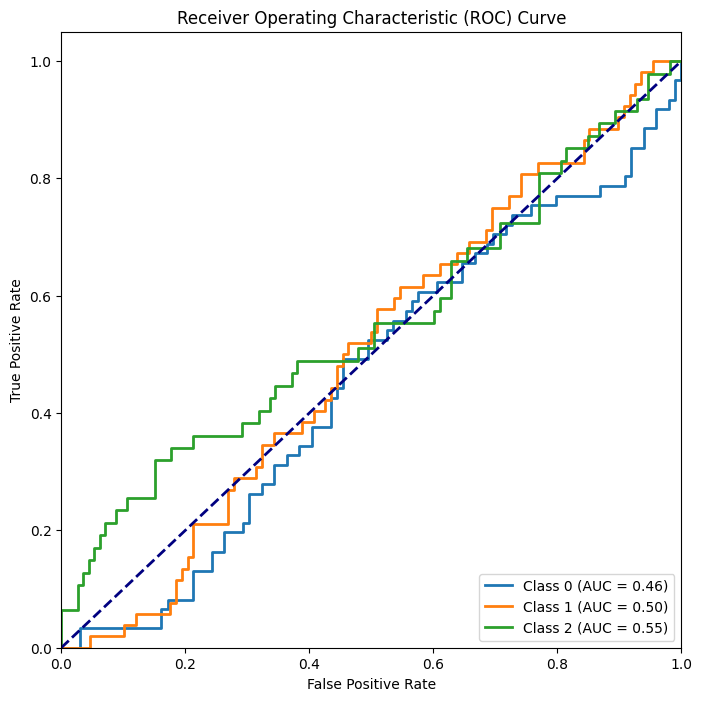

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
import cv2

# Generate some example data
# Replace this with your actual data loading and preprocessing steps
# For demonstration purposes, I'm using random data here.
np.random.seed(42)
x_train = np.random.rand(800, 256, 256, 3)  # Replace with your actual training data
y_train = np.random.randint(0, 3, 800)  # Replace with your actual training labels

# Convert labels to binary format
y_train_binary = label_binarize(y_train, classes=[0, 1, 2])

# Split the dataset
x_train, x_test, y_train_binary, y_test = train_test_split(x_train, y_train_binary, test_size=0.2, random_state=42)

# Build a simple CNN model (similar to your model architecture)
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=(256, 256, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])

# Train the model (replace with your actual training code)
epochs = 5
batch_size = 128
history = model.fit(x_train, y_train_binary, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):  # Assuming 3 classes, modify accordingly
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 8))

for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# y_pred = model.predict(x_test)

In [ ]:
# # Plotting image to compare
# img = array_to_img(x_test[2])
# img

In [ ]:
# # Finding max value from predition list and comaparing original value vs predicted
# print("Originally : ",all_labels[np.argmax(y_test[2])])
# print("Predicted : ",all_labels[np.argmax(y_pred[2])])

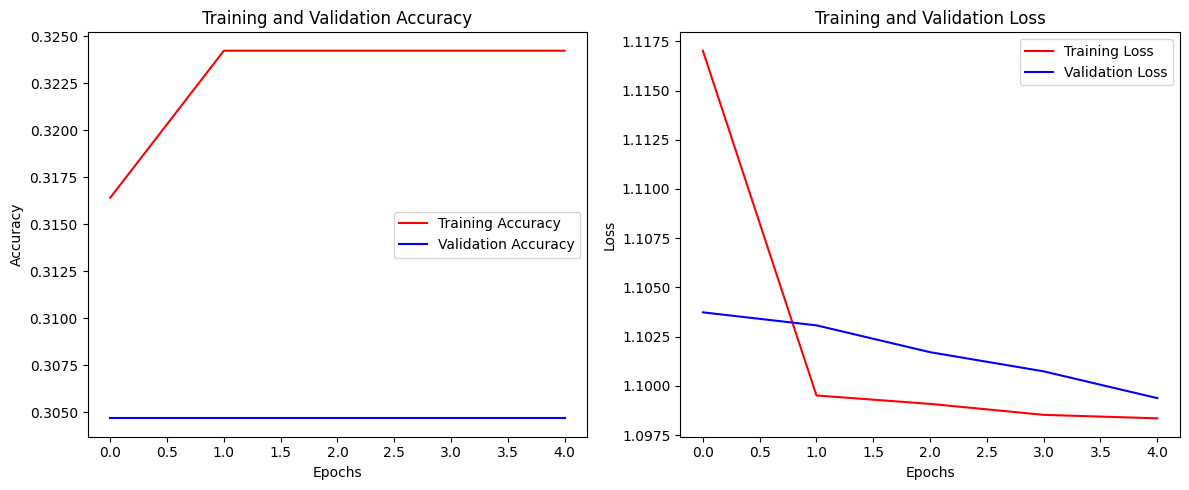

Optimizer Used: Adam
Number of Epochs: 50
Batch Size: 128


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable containing training history from the model.fit() function

# Plotting accuracy and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], color='r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color='r', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Displaying other information
print("Optimizer Used: Adam")
print("Number of Epochs: 50")
print("Batch Size: 128")
